# Abstract

Theme:
- BTC transaction values

Research Questions:
- Is there any difference of BTC transaction values between its time such as AM/PM or Even/Odd hours?

Methods:
- Conduct Bayesian statistical analysis on the difference of BTC transaction values between the below viewpoints:
  - AM vs PM hours such as 0-12 and 12-24
  - Even vs Odd hours such as 0,2,4,,, and 1,3,5,,,

Data:
- Daily BTC transactions from 2022-02 to 2022-04

Results and Conclusions:
- The BTC transaction values during PM hours are larger than those of AM hours statistically significantly.
- The BTC transaction values during odd hours are not larger than those of even hours statistically significantly.

Ref:
- http://nipper.work/btc/index.php?market=bitFlyer&coin=BTCJPY&periods=3600&after=1643673600&before=1651363140
- https://github.com/just4jc/DataCamp-3/blob/master/07-statistical-thinking-in-python-(part-2)/3-introduction-to-hypothesis-testing/permutation-test-on-frog-data.py


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
import pymc3 as pm
import arviz as az


pd.options.display.float_format = '{:,.2f}'.format
path = "../data"
path = '/content/drive/MyDrive/env_data_science/bitcoin_transactions_record/data'

In [8]:
# Read the sample data
df = pd.read_csv(path + "/01_raw/btc_202202_202204_per1h.csv", header=None, names=["datetime", "open", "close", "low", "high", "volumes"], parse_dates=['datetime'])

In [9]:
# Calculate the transaction values by multipling volumes by the average prices during the hour
df["transaction_values"] = df["volumes"] * (df["low"] + df["high"])/2

In [10]:
# Generate two arrays: am hours transaction values and pm hours transaction values
am_hours_arr = df[df["datetime"].dt.hour < 12]["transaction_values"].values
pm_hours_arr = df[df["datetime"].dt.hour >= 12]["transaction_values"].values

print(f"AM hours transaction values: {np.mean(am_hours_arr)}, PM hours transaction values: {np.mean(pm_hours_arr)}")

AM hours transaction values: 398815143.1690035, PM hours transaction values: 461020354.90046513


From the above sample comparisons, the mean of pm hours transaction values is larger than that of am hours transaction values?

In [11]:
# Generate two arrays: even hours transaction values and odd hours transaction values
even_hours_arr = df[df["datetime"].dt.hour %2 == 0]["transaction_values"].values
odd_hours_arr = df[df["datetime"].dt.hour %2 != 0]["transaction_values"].values

print(f"Even hours transaction values: {np.mean(even_hours_arr)}, Odd hours transaction values: {np.mean(odd_hours_arr)}")

Even hours transaction values: 423445570.65375066, Odd hours transaction values: 436389927.4157179


From the above sample comparisons, the mean of odd hours transaction values is a bit larger than that of even hours transaction values?

# AM vs PM hours

## Check the distributions

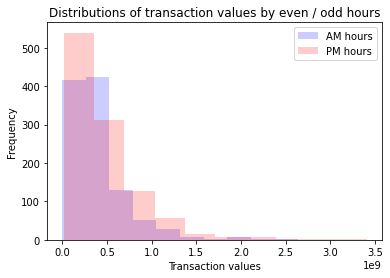

In [12]:
fig, ax1 = plt.subplots()

ax1.hist(am_hours_arr, color="b", alpha=0.2)
ax1.hist(pm_hours_arr, color="r", alpha=0.2)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["AM hours", "PM hours"]);

## It seems tough to compare the distributions by eyeballs.

In [13]:
d = np.mean(pm_hours_arr) - np.mean(am_hours_arr)
d

## How much rare is this sample of difference when we assume these two samples come from the same pupulation distribution?

62205211.731461644

In [14]:
print('Observed dist:')
print(np.mean(pm_hours_arr))
print(np.var(pm_hours_arr))
print(np.mean(am_hours_arr))
print(np.var(am_hours_arr))

pm_simulated_expo = np.random.exponential(scale=np.mean(pm_hours_arr), size=100000)
am_simulated_expo = np.random.exponential(scale=np.mean(am_hours_arr), size=100000)
print('Expontential dist:')
print(np.mean(pm_simulated_expo))
print(np.var(pm_simulated_expo))
print(np.mean(am_simulated_expo))
print(np.var(am_simulated_expo))

pm_simulated_gamma = np.random.gamma(shape=(np.mean(pm_hours_arr)**2)/np.var(pm_simulated_expo), scale=np.var(pm_simulated_expo)/np.mean(pm_hours_arr), size=100000)
am_simulated_gamma = np.random.gamma(shape=np.mean(am_hours_arr)**2/np.var(am_simulated_expo), scale=np.var(am_simulated_expo)/np.mean(am_hours_arr), size=100000)
print('Gamma dist:')
print(np.mean(pm_simulated_gamma))
print(np.var(pm_simulated_gamma))
print(np.mean(am_simulated_gamma))
print(np.var(am_simulated_gamma))

## Assuming the prior-distribution as the Gamma distribution looks reasonable, right?

Observed dist:
461020354.90046513
1.544245255918648e+17
398815143.1690035
1.0397077094513227e+17
Expontential dist:
459960097.77778673
2.1346975835326218e+17
399191214.5397419
1.5949075253685814e+17
Gamma dist:
458869356.35663337
2.0987925582995584e+17
398763189.72200155
1.5982462295249555e+17


## Bayesian modeling

In [61]:
# Define model and inference
with pm.Model() as model:
    mu = pm.HalfNormal('mu', sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)
    obs = pm.Gamma('obs', mu=mu, sigma=sigma, observed=pm_hours_arr)

with model:
    trace = pm.sample(3000, return_inferencedata=False)
    idata = az.from_pymc3(trace)


You can find the C code in this temporary file: C:\Users\yuzyh\AppData\Local\Temp\theano_compilation_error_4zu8vyh3


Exception: ('Compilation failed (return status=1): C:\\Users\\yuzyh\\AppData\\Local\\Temp\\ccpOqo6W.s: Assembler messages:\r. C:\\Users\\yuzyh\\AppData\\Local\\Temp\\ccpOqo6W.s:112: Error: invalid register for .seh_savexmm\r. ', 'FunctionGraph(Elemwise{eq,no_inplace}(TensorConstant{[3.9106921..25152e+08]}, <TensorType(int8, (True,))>))')

# Even vs Odd hours

## Check the distributions

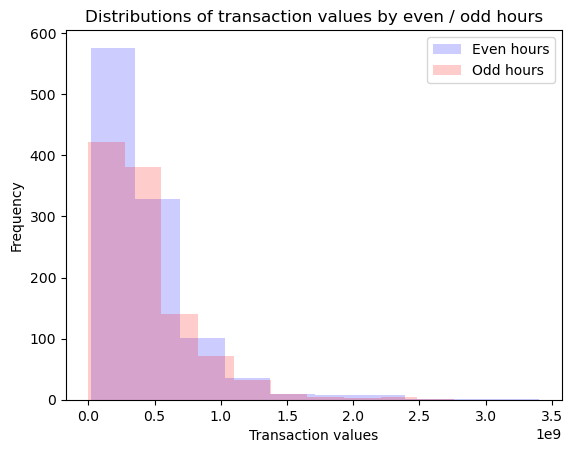

In [ ]:
fig, ax1 = plt.subplots()

ax1.hist(even_hours_arr, color="b", alpha=0.2)
ax1.hist(odd_hours_arr, color="r", alpha=0.2)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["Even hours", "Odd hours"]);

## It seems tough to compare the distributions by eyeballs.

In [ ]:
d = np.mean(odd_hours_arr) - np.mean(even_hours_arr)
d
# How much rare is this sample of difference when we assume these two samples come from the same pupulation distribution?


12944356.761967242